## Feature Engineering

In [43]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

In [5]:
pre_path = '../data/2.Preprocessed/'
path = '../data/3.Feature_Engineered/'

### 유저의 주문 기반 신구 선호도
유저가 주문한 책 중에 2020년 출판된 도서가 많은지

#### products: 2020년에 출판된 도서는 모두 예전 도서로 취급

In [39]:
products = pd.read_csv(pre_path+'products_preprocessed.csv',dtype={'category_id':str})

In [34]:
products['pub_newold'] = products['published_at'].astype(str).apply(lambda x: 1 if x[0:4] == '2020' else 0)

In [35]:
products.dropna(inplace=True) #maker name에 na 존재
products.isnull().sum()

product_id        0
product_name      0
published_at      0
maker_name        0
pub_0             0
pub_1             0
pub_2             0
pub_3             0
pub_4             0
category_id_01    0
category_id_02    0
category_id_03    0
category_id_04    0
category_id_05    0
category_id_06    0
category_id_07    0
category_id_08    0
category_id_09    0
category_id_10    0
category_id_11    0
category_id_12    0
category_id_13    0
category_id_14    0
category_id_15    0
category_id_16    0
category_id_17    0
category_id_18    0
category_id_19    0
category_id_20    0
category_id_22    0
category_id_23    0
category_id_25    0
category_id_26    0
category_id_27    0
category_id_28    0
category_id_29    0
category_id_30    0
category_id_31    0
category_id_33    0
category_id_34    0
shop_price_0      0
shop_price_1      0
shop_price_2      0
shop_price_3      0
pub_newold        0
dtype: int64

#### product + order

In [40]:
orders = pd.read_csv(pre_path+'orders_only_in_clicks.csv')

In [37]:
orders['created_at']= orders['created_at'].astype('datetime64[ns]')

In [38]:
orders_products = pd.merge(orders, products, on='product_id',how='left')

In [39]:
print(orders_products.isnull().sum())
orders_products.dropna(inplace=True)

order_id             0
account_id           0
product_id           0
price                0
created_at           0
product_name      2157
published_at      2157
maker_name        2157
pub_0             2157
pub_1             2157
pub_2             2157
pub_3             2157
pub_4             2157
category_id_01    2157
category_id_02    2157
category_id_03    2157
category_id_04    2157
category_id_05    2157
category_id_06    2157
category_id_07    2157
category_id_08    2157
category_id_09    2157
category_id_10    2157
category_id_11    2157
category_id_12    2157
category_id_13    2157
category_id_14    2157
category_id_15    2157
category_id_16    2157
category_id_17    2157
category_id_18    2157
category_id_19    2157
category_id_20    2157
category_id_22    2157
category_id_23    2157
category_id_25    2157
category_id_26    2157
category_id_27    2157
category_id_28    2157
category_id_29    2157
category_id_30    2157
category_id_31    2157
category_id_33    2157
category_id

#### preference: mean을 통해 신구선호도 집계, 1에 가까울 수록 신규도서 선호 (train)

In [40]:
preference = pd.DataFrame(orders_products.groupby('account_id')['pub_newold'].agg('mean')).reset_index()
preference.rename(columns = {'pub_newold':'new_preference'}, inplace=True)

In [41]:
preference

,account_id,new_preference
0,100004,0.09
1,100033,0.33
2,100039,0.07
3,100040,1.00
4,100058,0.00
...,...,...
796078,16960360,1.00
796079,16960378,0.00
796080,16960382,0.00
796081,16960413,1.00


In [42]:
orders_preference = pd.merge(orders, preference, on='account_id', how='left')

<AxesSubplot:>

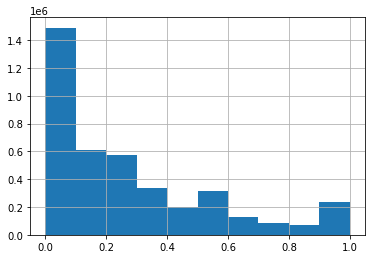

In [44]:
orders_preference.new_preference.hist()

#### preference: 0.5 기준으로 0, 1로 바꿈

In [45]:
orders_preference['new_pref'] = orders_preference['new_preference'].apply(lambda x: 1 if x>=0.5 else 0)

In [49]:
orders_preference.to_csv(path+'orders_preference_train.csv',encoding='utf-8', index=None)

### 유저의 클릭 기반 신구 선호도
유저가 클릭한 책 중에 2020년에 출판된 책의 비율이 많은지

#### click: 3월 1일 ~ 4월 30일, 그리고 3월 1일 이전 데이터(train) / 5월 1일 이후 데이터 (test)

In [21]:
click = pd.read_csv(pre_path+'click.csv')

In [ ]:
click['request_date_time'] = click['request_date_time'].astype('datetime64[ns]')

#### click + product (train, test)

In [52]:
click_product = pd.merge(click,products,on='product_id',how='left')
click_product.dropna(inplace=True)

#### preference: mean을 통해 신규선호도 집계, 1에 가까울수록 신규도서 선호 (train, test)

In [53]:
preference = pd.DataFrame(click_product.groupby('account_id')['pub_newold'].agg('mean')).reset_index()
preference.rename(columns = {'pub_newold':'new_preference'}, inplace=True)

#### product + click + preference (train, test)

In [54]:
click_preference = pd.merge(click_product,preference, on='account_id',how='left')

<AxesSubplot:>

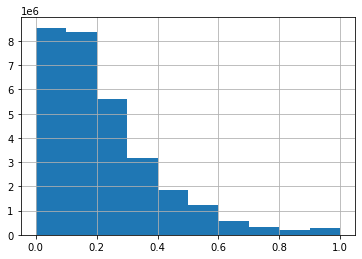

In [55]:
click_preference.new_preference.hist()

#### preference: 0.5 기준 0,1 로 바꿈

In [ ]:
click_preference['new_pref'] = click_preference['new_preference'].apply(lambda x: 1 if x>=0.5 else 0)

In [56]:
click_preference.to_csv(path+'click_preference.csv',encoding='utf-8', index=None)

### 활동시간

In [12]:
users = pd.read_csv(pre_path+'accounts_preprocessed.csv',encoding='utf-8')

In [68]:
click['time'] = click['request_date_time'].str.slice(start=11, stop=13)
click['day'] = click['request_date_time'].str.slice(start=0,stop=11)

#### 활동시간대

In [79]:
click['click_time'] = click['time'].apply(lambda x:'day' if int(x) in list(range(6,19)) else 'night')

In [80]:
click = pd.get_dummies(click, columns=['click_time'])

In [82]:
ct_grp = click.groupby('account_id')

In [85]:
acc_times = ct_grp.sum().iloc[:,[4,5]]

In [86]:
acc_times.to_csv(path+'user_activity_times.csv') #only_activitiy_times_0623.csv

#### 활동 요일

In [ ]:
click = click.sort_values(by=['account_id'])

In [91]:
click['week_day'] = pd.to_datetime(click.day).dt.day_name()

In [ ]:
#clicks.to_csv('./clicks_day_time_weekday_0624.csv')

#### 활동 주말 vs 평일

In [92]:
click['weekend'] = click['week_day'].apply(lambda x: 1 if x in ['Sunday','Saturday'] else 0)

In [95]:
click = pd.get_dummies(click, columns=['weekend'])

#### 활동 시간 비율

In [100]:
user_click_agg = click.drop('week_day', axis=1)
user_click_sum = user_click_agg.groupby('account_id').sum().iloc[:, -4:]

In [103]:
user_click_sum['day_ratio'] = user_click_sum.apply(lambda x:x['click_time_day'] / (x['click_time_day'] + x['click_time_night']), axis=1)
user_click_sum['weekend_ratio'] = user_click_sum.apply(lambda x:x['weekend_1'] / (x['weekend_0'] + x['weekend_1']), axis=1)

In [104]:
user_click_sum

,click_time_day,click_time_night,weekend_0,weekend_1,day_ratio,weekend_ratio
account_id,,,,,,
100004,14.00,27.00,30.00,11.00,0.34,0.27
100033,65.00,9.00,46.00,28.00,0.88,0.38
100039,70.00,59.00,97.00,32.00,0.54,0.25
100040,2.00,0.00,0.00,2.00,1.00,1.00
100058,57.00,59.00,110.00,6.00,0.49,0.05
...,...,...,...,...,...,...
16960360,0.00,1.00,0.00,1.00,0.00,1.00
16960378,0.00,4.00,0.00,4.00,0.00,1.00
16960382,0.00,1.00,0.00,1.00,0.00,1.00


In [105]:
user_click_sum.to_csv(path+'user_click_activitytimes.csv', index=None)

### 카테고리 선호도

In [9]:
click_pro = pd.read_csv(path+'user_click_new_preference.csv')
click_pro.head()

,request_date_time,account_id,product_id,before_product_id,device_type_M,device_type_P,product_name,published_at,maker_name,pub_0,...,category_id_30,category_id_31,category_id_33,category_id_34,shop_price_0,shop_price_1,shop_price_2,shop_price_3,pub_newold,new_preference
0,2020-03-14 10:39:45,101496,88429694,0,1,0,먼 바다,2020-02-17 00:00:00,해냄,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.258621
1,2020-03-24 15:33:35,101496,64694842,0,1,0,당신이 옳다,2018-10-10 00:00:00,해냄,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258621
2,2019-12-31 09:54:33,101496,81503945,0,1,0,"[예스리커버] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365",2019-10-30 00:00:00,위즈덤하우스,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258621
3,2019-12-31 09:52:14,101496,84434768,0,1,0,오늘도 펭수 내일도 펭수 (꽃눈 에디션),2019-12-19 00:00:00,놀,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.258621
4,2019-12-31 09:52:25,101496,81503945,0,1,0,"[예스리커버] 1일 1페이지, 세상에서 가장 짧은 교양 수업 365",2019-10-30 00:00:00,위즈덤하우스,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258621


In [10]:
cate_cols = [col for col in click_pro.columns if col.startswith('category')]
cate_click_pro = click_pro[['account_id', 'product_id'] + cate_cols]

In [13]:
user_click_pro = pd.merge(users, cate_click_pro, how='left', on='account_id')

In [14]:
user_click_pro_sum = user_click_pro.groupby('account_id').sum()
user_click_pro_sum

,gender_M,gender_F,age,address_is,product_id,category_id_01,category_id_02,category_id_03,category_id_04,category_id_05,...,category_id_23,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_30,category_id_31,category_id_33,category_id_34
account_id,,,,,,,,,,,,,,,,,,,,,
100001,1,0,4,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,41,164,0,2.985000e+09,1.0,0.0,17.0,0.0,1.0,...,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,2.0
100014,0,1,4,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100018,0,1,4,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100020,1,0,5,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16991185,1,0,3,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16991193,1,0,2,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16991195,1,0,3,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
user_click_pro_sum.iloc[:, 5:] = user_click_pro_sum.iloc[:, 5:].div(user_click_pro_sum.iloc[:, 5:].sum(axis=1), axis='index').fillna(0)

In [19]:
user_click_pro_sum.to_csv(path+'user_click_cat_preference.csv')

### 관여도

#### click

In [26]:
account_click_count = click.groupby('account_id').count().iloc[:, 0]

In [27]:
account_click_count.to_csv(path + 'account_click_count.csv', index=None)

#### order

In [32]:
account_order_count = orders.groupby('account_id').count()['order_id']

In [34]:
account_order_count.to_csv('account_order_count.csv', index=None)

#### 관여도 (클릭수 / 주문수)

In [38]:
inv = account_click_count.div(account_order_count, axis='index').reset_index().rename({0:'involvement'}, axis=1)
inv.to_csv('user_involvement.csv', index=None)

### bestseller

In [52]:
products['category_id'] = products[cate_cols].idxmax(axis=1).str[-2:]

In [54]:
#order, product 데이터 merge
pro_pre = products[['category_id','product_id']]
best = pd.merge(orders, pro_pre, on='product_id', how='left')
best.isnull().sum()
best.dropna(inplace=True)

In [55]:
best.head()

,order_id,account_id,product_id,price,created_at,category_id
0,222798861,104533,89967507,48600.00,2020-05-24 22:16:05.020,13
1,217109953,104533,234373,18000.00,2020-03-11 22:59:53.880,13
2,220523812,106728,38972963,12600.00,2020-04-21 17:15:15.880,03
3,220523812,106728,69645132,9000.00,2020-04-21 17:15:15.880,03
4,216465952,106728,8157957,13320.00,2020-03-04 18:19:32.886,33


In [56]:
#created_at(주문일) count하여 특정 카테고리 내 특정 도서 구매량 비교
best_by_category = pd.DataFrame(best.groupby(['category_id','product_id']).count()['created_at']).sort_values('created_at', ascending=False)



In [57]:
best_by_category

created_at
category_id product_id            
22          89309569         12233
03          85927912          8961
27          89512708          8910
            89484458          8794
03          85927903          8610
...                            ...
16          90232736             1
            90228077             1
            90224661             1
05          4170526              1
01          9130                 1

[229221 rows x 1 columns]

In [58]:
#주문량이 가장 많은 순대로 200권 선정(리스트)
best200_nocat = best_by_category.sort_values(['created_at'],ascending=False)[0:200].reset_index()['product_id'].tolist()



In [90]:
cat_best24_list = []
for i in range(0, 24):
    category_best24 = best_by_category.sort_values(['category_id', 'created_at'], ascending=False).unstack(level=0).iloc[:, i].sort_values(ascending=False)[:24].index.to_list()
    cat_best24_list.extend(category_best24)


In [94]:
products['best200'] = products['product_id'].apply(lambda x:1 if x in best200_nocat else 0)
len(products[products['best200']==1])

200

In [95]:
products['bestcat24'] = products['product_id'].apply(lambda x:1 if x in cat_best24_list else 0)
len(products[products['bestcat24']==1])

576

In [103]:
#products.drop('category_id', axis=1, inplace=True)
products.to_csv(path+'bestseller_product.csv', index=None)

In [102]:
path

'../data/3.Feature_Engineered/'